In [1]:
import h5py, os, torch
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

## Outline
 - Generate a specific model for each scene
     - Each location: 1600 images w/o presence, 800 imags w/ presence
 - Create Dataloader
     - 80-20 split for training/testing (validation?)
     - Each img (input size): 1024 x 720 px
 - Model Architecture
     - Modified VGG16?
     - Custom CNN architecture?
     - Concatenate pixel values and put in logistic regression?

---

## Model Base/Helpers/Train & Test functions

In [3]:
def accuracy(outs, labels):
    res = {}
    # check accuracy for 3 different thresholds
    for th in [.50, .75, .80]:
        outs_th = outs >= th
        # append onto result dictionary to be returned to function that called `accuracy()`
        res[th] = torch.tensor(torch.sum(outs_th == labels).item() / len(outs))
    return res

In [4]:
class ModelBase(nn.Module):
#     training step
    def train_step(self, batch):
        xb, labels = batch
        labels = labels.view(-1, 1)
        outs = self(xb)
        loss = F.binary_cross_entropy(outs, labels)
        return loss
#     validation step
    def val_step(self, batch):
        xb, labels = batch
        labels = labels.view(-1, 1)
        outs = self(xb)
        loss = F.binary_cross_entropy(outs, labels)
        acc = accuracy(outs, labels)
        return {'loss': loss.detach(), 'acc': acc}
#     validation epoch (avg accuracies and losses)
    def val_epoch_end(self, outputs):
#         for i in range(10):
#             print(outputs[i])
        batch_loss = [x['loss'] for x in outputs]
        avg_loss = torch.stack(batch_loss).mean()
        batch_acc50 = [x['acc'][.50] for x in outputs]
        batch_acc75 = [x['acc'][.75] for x in outputs]
        batch_acc80 = [x['acc'][.80] for x in outputs]
        avg_acc50 = torch.stack(batch_acc50).mean()
        avg_acc75 = torch.stack(batch_acc75).mean()
        avg_acc80 = torch.stack(batch_acc80).mean()
        return {'avg_loss': avg_loss, 'avg_acc': [avg_acc50, avg_acc75, avg_acc80]}
#     print everything important
    def epoch_end(self, epoch, avgs, test=False):
        s = 'test' if test else 'val'
        print(f'EPOCH {epoch + 1:<10} | {s}_loss:{avgs["avg_loss"]:.3f}, {s}_acc (threshold): (.50){avgs["avg_acc"][0]:.3f}, (.75){avgs["avg_acc"][1]:.3f}, (.80){avgs["avg_acc"][2]:.3f}')

In [5]:
@torch.no_grad()
def evaluate(model, val_dl):
    # eval mode
    model.eval()
    outputs = [model.val_step(batch) for batch in val_dl]
    return model.val_epoch_end(outputs)


def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    # define optimizer
    optimizer = opt_func(model.parameters(), lr)
    # for each epoch...
    for epoch in range(epochs):
        # training mode
        model.train()
        # (training) for each batch in train_dl...
        for batch in tqdm(train_dl):
            # pass thru model
            loss = model.train_step(batch)
            # perform gradient descent
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # validation
        res = evaluate(model, val_dl)
        # print everything useful
        model.epoch_end(epoch, res, test=False)
        # append to history
        history.append(res)
    return history

---

## Models

In [6]:
class VGG16_PT(ModelBase):
    def __init__(self):
        super().__init__()
#         pretrained VGG16 model w/ batch norm
        self.network = torchvision.models.vgg16_bn(pretrained=True)
#         change first layer to accept only 1 dimension of color (b/w)
        self.network.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
#         change last fc layer to output one value
        self.network.classifier[6] = nn.Linear(4096, 1, bias=True)
        
    def forward(self, xb):
        out = self.network(xb)
        out = F.sigmoid(out)
        return out

In [7]:
class VGG11_PT(ModelBase):
    def __init__(self):
        super().__init__()
#         pretrained VGG16 model w/ batch norm
        self.network = torchvision.models.vgg11_bn(pretrained=True)
#         change first layer to accept only 1 dimension of color (b/w)
        self.network.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
#         change last fc layer to output one value
        self.network.classifier[6] = nn.Linear(4096, 1, bias=True)
        
    def forward(self, xb):
        out = self.network(xb)
        out = F.sigmoid(out)
        return out

In [8]:
# class Custom_NPT(ModelBase):
#     def __init__(self):
#         super().__init__()                                       # 1 x 1024 x 720
# #         custom-defined model w/o pretrained weights
#         self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)   # 8 x 1024 x 720
#         self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # 16 x 1024 x 720
#         self.pool1 = nn.MaxPool2d(2)                             # 16 x 512 x 360
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 32 x 512 x 360
#         self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # 32 x 512 x 360
#         self.pool2 = nn.MaxPool2d(2)                             # 32 x 256 x 180
#         self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1) # 16 x 256 x 180
#         self.pool3 = nn.MaxPool2d(2)                             # 8 x 256 x 180
#         self.fc1 = nn.Linear(8*256*180, 4096)
#         self.fc2 = nn.Linear(4096, 512)
#         self.fc3 = nn.Linear(512, 1)
        
#     def forward(self, xb):
#         out = F.relu(self.conv1(xb))
#         out = F.relu(self.conv2(out))
#         out = self.pool1(out)
#         out = F.relu(self.conv3(out))
#         out = F.relu(self.conv4(out))
#         out = self.pool2(out)
#         out = F.relu(self.conv5(out))
#         out = self.pool3(out)
        
#         out = torch.flatten(out, 1)
#         out = F.relu(self.fc1(out))

In [9]:
class VGG16_NPT(ModelBase):
    def __init__(self):
        super().__init__()
#         pretrained VGG16 model w/ batch norm
        self.network = torchvision.models.vgg16_bn(pretrained=False)
#         change first layer to accept only 1 dimension of color (b/w)
        self.network.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
#         change last fc layer to output one value
        self.network.classifier[6] = nn.Linear(4096, 1, bias=True)
        
    def forward(self, xb):
        out = self.network(xb)
        out = F.sigmoid(out)
        return out

---

## DataSet & DataLoader

In [10]:
# class Prudhoe_DS(Dataset):
#     def __init__(self, h5_pth, transforms=None):
#         self.transforms = transforms
#         self.h5_pth = h5_pth
#         self.mask_locs = []
        
#         with h5py.File(self.h5_pth, 'r') as F:
#             pos_shape = F['POS'].attrs['shape'][0]
#             neg_shape = F['NEG'].attrs['shape'][0]
#             for shape, key in zip([pos_shape, neg_shape], ['POS', 'NEG']):
#                 for i in range(shape):
#                     self.mask_locs.append({'key': key,
#                                           'key_idx': i})
        
#     def __len__(self):
#         return len(self.mask_locs)
    
#     def __getitem__(self, idx):
#         mask_loc = self.mask_locs[idx]
#         with h5py.File(self.h5_pth, 'r') as F:
#             mask = F[mask_loc['key']][mask_loc['key_idx']]
#             mask = np.array(mask)
            
#             if self.transforms:
#                 mask = self.transforms()(mask)
# #             mask = mask.unsqueeze(0)
            
#         label = 1 if mask_loc['key'] == 'POS' else 0
#         return mask, label

In [11]:
# class Prudhoe_DS_v2(Dataset):
#     def __init__(self, h5_pth, transforms=None):
#         self.transforms = transforms
#         self.h5_pth = h5_pth
#         self.masks = []
#         self.labels = []
        
#         with h5py.File(self.h5_pth, 'r') as F:
#             pos = F['POS']
#             neg = F['NEG']
#             pos_len = pos.attrs['shape'][0]
#             neg_len = neg.attrs['shape'][0]
            
#             self.masks = np.expand_dims(np.vstack([pos, neg]), axis=1).astype('float32')
#             self.labels = np.concatenate([np.ones(pos_len),
#                                           np.zeros(neg_len)]).astype('float32')
        
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         mask = self.masks[idx]
#         label = self.labels[idx]
        
#         return mask, label

In [12]:
class Prudhoe_DS(Dataset):
    def __init__(self, npy_pth, transforms=None):
        self.transforms = transforms
        self.npy_pth = npy_pth
        self.masks_loc = []
        self.labels = []
        
        for typ in ['pos', 'neg']:
            for fn in os.listdir(os.path.join(self.npy_pth, typ)):
                
                full_fn = os.path.join(self.npy_pth, typ, fn)
                self.masks_loc.append(full_fn)
#                 masks.append(np.load(full_fn))
                
                label = 1 if typ == 'pos' else 0
                self.labels.append(label)
        
        self.masks_loc = np.array(self.masks_loc)
        self.labels = np.array(self.labels).astype('float32')
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        mask = np.expand_dims(np.load(self.masks_loc[idx]), axis=0).astype('float32')
        label = self.labels[idx]
        
        if self.transforms:
            mask = self.transforms()(mask)
        
        return mask, label

---

In [13]:
torch.manual_seed(42)

In [14]:
PTH = '/scratch/richardso21/20-21_BGSUB/'
site = 'prudhoe_12'

In [15]:
npy_pth = os.path.join(PTH, 'FgSegNet_O_neg', site)

In [16]:
ds = Prudhoe_DS(npy_pth)
ds_size = len(ds)

In [17]:
# for i in ds:
#     print(i, i[0].shape)
#     break

In [18]:
train_size = int(ds_size * .70)
val_size = (ds_size - train_size) // 2
test_size = ds_size - train_size - val_size

In [19]:
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])

In [20]:
batch_size = 2

In [21]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size*2, pin_memory=True, num_workers=4)

In [22]:
# from torchvision.utils import make_grid

In [23]:
# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     print(_)
#     plt.figure(figsize=(12,6))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=2).permute((1, 2, 0)))
#     break

---

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [28]:
model = to_device(VGG11_PT(), device)

In [29]:
history = []

In [30]:
# history = [evaluate(model, val_loader)]
# history

In [31]:
history += fit(20, 1e-5, model, train_loader, val_loader)

  0%|          | 0/991 [00:00<?, ?it/s]/scratch/richardso21/conda/envs/fgsegnet/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 1          | val_loss:0.634, val_acc (threshold): (.50)0.664, (.75)0.636, (.80)0.636


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 2          | val_loss:0.615, val_acc (threshold): (.50)0.680, (.75)0.636, (.80)0.633


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 3          | val_loss:0.643, val_acc (threshold): (.50)0.638, (.75)0.633, (.80)0.633


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 4          | val_loss:0.448, val_acc (threshold): (.50)0.808, (.75)0.713, (.80)0.685


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 5          | val_loss:0.631, val_acc (threshold): (.50)0.664, (.75)0.636, (.80)0.636


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 6          | val_loss:0.601, val_acc (threshold): (.50)0.685, (.75)0.636, (.80)0.636


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 7          | val_loss:0.371, val_acc (threshold): (.50)0.874, (.75)0.836, (.80)0.792


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 8          | val_loss:0.412, val_acc (threshold): (.50)0.839, (.75)0.773, (.80)0.759


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 9          | val_loss:0.641, val_acc (threshold): (.50)0.650, (.75)0.631, (.80)0.636


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 10         | val_loss:0.550, val_acc (threshold): (.50)0.748, (.75)0.685, (.80)0.678


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 11         | val_loss:0.466, val_acc (threshold): (.50)0.836, (.75)0.715, (.80)0.692


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 12         | val_loss:0.470, val_acc (threshold): (.50)0.836, (.75)0.759, (.80)0.748


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 13         | val_loss:0.560, val_acc (threshold): (.50)0.741, (.75)0.769, (.80)0.743


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 14         | val_loss:0.479, val_acc (threshold): (.50)0.804, (.75)0.773, (.80)0.738


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 15         | val_loss:0.465, val_acc (threshold): (.50)0.808, (.75)0.785, (.80)0.764


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 16         | val_loss:0.526, val_acc (threshold): (.50)0.748, (.75)0.706, (.80)0.703


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 17         | val_loss:0.501, val_acc (threshold): (.50)0.794, (.75)0.741, (.80)0.722


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 18         | val_loss:0.592, val_acc (threshold): (.50)0.708, (.75)0.680, (.80)0.673


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 19         | val_loss:0.586, val_acc (threshold): (.50)0.722, (.75)0.685, (.80)0.673


100%|██████████| 991/991 [03:01<00:00,  5.45it/s]


EPOCH 20         | val_loss:0.951, val_acc (threshold): (.50)0.843, (.75)0.829, (.80)0.801


In [32]:
# torch.cuda.empty_cache()

In [33]:
torch.save(model.state_dict(), '/scratch/richardso21/20-21_BGSUB/prescenceCNN.pth')

In [34]:
history += fit(10, 1e-6, model, train_loader, val_loader)

  0%|          | 0/991 [00:00<?, ?it/s]/scratch/richardso21/conda/envs/fgsegnet/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 1          | val_loss:0.926, val_acc (threshold): (.50)0.808, (.75)0.762, (.80)0.741


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 2          | val_loss:0.645, val_acc (threshold): (.50)0.685, (.75)0.631, (.80)0.631


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 3          | val_loss:0.622, val_acc (threshold): (.50)0.867, (.75)0.825, (.80)0.794


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 4          | val_loss:0.607, val_acc (threshold): (.50)0.699, (.75)0.675, (.80)0.671


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 5          | val_loss:0.475, val_acc (threshold): (.50)0.797, (.75)0.745, (.80)0.729


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 6          | val_loss:0.627, val_acc (threshold): (.50)0.876, (.75)0.850, (.80)0.839


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 7          | val_loss:0.588, val_acc (threshold): (.50)0.706, (.75)0.678, (.80)0.668


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 8          | val_loss:0.637, val_acc (threshold): (.50)0.848, (.75)0.829, (.80)0.804


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 9          | val_loss:0.576, val_acc (threshold): (.50)0.734, (.75)0.694, (.80)0.678


100%|██████████| 991/991 [03:00<00:00,  5.50it/s]


EPOCH 10         | val_loss:0.593, val_acc (threshold): (.50)0.703, (.75)0.692, (.80)0.675


In [35]:
history += fit(5, 1e-7, model, train_loader, val_loader)

  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 1          | val_loss:0.600, val_acc (threshold): (.50)0.696, (.75)0.671, (.80)0.668


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 2          | val_loss:0.561, val_acc (threshold): (.50)0.734, (.75)0.706, (.80)0.694


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 3          | val_loss:0.680, val_acc (threshold): (.50)0.787, (.75)0.778, (.80)0.745


  0%|          | 0/991 [00:00<?, ?it/s]

EPOCH 4          | val_loss:0.618, val_acc (threshold): (.50)0.692, (.75)0.645, (.80)0.638


100%|██████████| 991/991 [03:00<00:00,  5.50it/s]


EPOCH 5          | val_loss:0.561, val_acc (threshold): (.50)0.743, (.75)0.706, (.80)0.687


In [36]:
torch.cuda.empty_cache()

---

In [38]:
history[:2]

[{'avg_loss': tensor(0.6344, device='cuda:0'),
  'avg_acc': [tensor(0.6636), tensor(0.6355), tensor(0.6355)]},
 {'avg_loss': tensor(0.6152, device='cuda:0'),
  'avg_acc': [tensor(0.6799), tensor(0.6355), tensor(0.6332)]}]

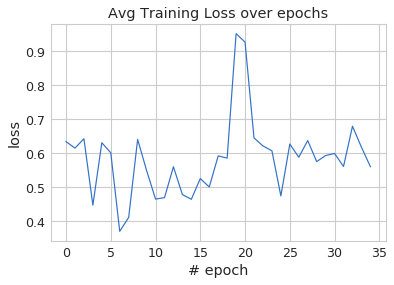

In [39]:
plt.plot([x['avg_loss'] for x in history])
plt.title('Avg Training Loss over epochs')
plt.ylabel('loss')
plt.xlabel('# epoch')
plt.show()

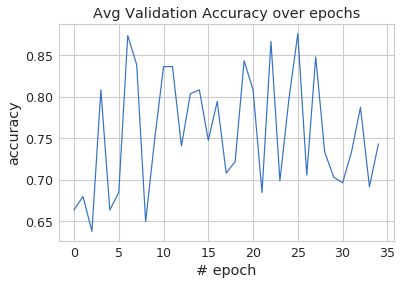

In [42]:
plt.plot([x['avg_acc'][0] for x in history])
plt.title('Avg Validation Accuracy over epochs')
plt.ylabel('accuracy')
plt.xlabel('# epoch')
plt.show()